<a href="https://colab.research.google.com/github/kelvin-kiplagat/DTE-Team-5/blob/main/DTE_Team_5_Phase_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


**Datasets**
- Full paths to the datasets

In [ ]:
access_path = './drive/MyDrive/Datathon/Phase II/Data'

In [ ]:
# Read in the dataframes
cancer_df, covid_df, heart_df, hiv_df, malaria_df, pneumonia_df = [pd.read_csv(access_path + f"/{fname}") for fname in os.listdir(access_path)]

datasets = [cancer_df, covid_df, heart_df, hiv_df, malaria_df, pneumonia_df]
study_areas = ["cancer", "covid", "heart", "HIV", "malaria", "pneumonia"]
cols_to_drop = ['nct_number', 'study_title', 'study_url', 'acronym', 'brief_summary', 'other_ids', 'study_documents'] #'secondary_outcome_measures', 'primary_outcome_measures'


# process the column names, drop unnecessary columns, and merge the dataframes into one big dataframe
clinical_df = pd.DataFrame()
for i in range(len(datasets)):
    df = datasets[i]
    disease_of_interest = study_areas[i]
    df.columns = [col.lower().replace(" ","_") for col in df.columns]
    df_ = df.drop(columns = cols_to_drop)
    df_['study_area'] = disease_of_interest
    clinical_df = pd.concat([clinical_df, df_], axis = 0, ignore_index = True)

# Preprocess date columns
date_columns = ["start_date", "primary_completion_date", "completion_date", "first_posted", "results_first_posted", "last_update_posted"]
clinical_df[date_columns] = reduce(lambda x, y : pd.concat([x, y], axis = 1), [pd.to_datetime(clinical_df[col], format = "%Y-%m-%d", errors = "coerce") for col in date_columns])
clinical_df['start_year'] = clinical_df.start_date.apply(lambda x : x.year)
clinical_df['days_to_completion'] = (clinical_df.completion_date - clinical_df.start_date).apply(lambda x : x.days)

print("Total Number of Observations: ",clinical_df.shape[0])
print(clinical_df.info())
clinical_df.sample(5)

Total Number of Observations:  161863
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161863 entries, 0 to 161862
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   study_status                161863 non-null  object        
 1   study_results               161863 non-null  object        
 2   conditions                  161857 non-null  object        
 3   interventions               144610 non-null  object        
 4   primary_outcome_measures    153676 non-null  object        
 5   secondary_outcome_measures  119675 non-null  object        
 6   other_outcome_measures      13107 non-null   object        
 7   sponsor                     161863 non-null  object        
 8   collaborators               60820 non-null   object        
 9   sex                         161698 non-null  object        
 10  age                         161863 non-null  object        
 11  p

,study_status,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,...,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_area,start_year,days_to_completion
127997,UNKNOWN,NO,Acute Kidney Injury,DRUG: Vitamin C|DRUG: Control (Normal saline),"Postoperative acute kidney injury, Compare the...",Postoperative oxidative stress and vascular in...,NaN,Yonsei University,NaN,ALL,...,2020-03-24,2022-12-01,2022-12-01,2019-12-24,NaT,2020-03-26,Department of Anesthesiology and Pain Medicine...,heart,2020.0,982.0
79665,RECRUITING,NO,Advanced Malignant Tumors,DRUG: doxorubicin hydrochloride liposome injec...,The content of natural IgM in patients' blood ...,NaN,NaN,Fudan University,NaN,ALL,...,2000-03-01,2022-06-01,2022-11-01,2022-04-29,NaT,2022-04-29,"Fudan University Shanghai Cancer Center, Shang...",cancer,2000.0,8280.0
103256,UNKNOWN,NO,Obesity|Telemedicine|Bariatric Surgery,NaN,"Rejection rate (%), The rejection rate to the ...","Excess Weight Loss percentage (EWL%), The pati...",NaN,University of Roma La Sapienza,NaN,ALL,...,2020-06-01,2020-07-22,2020-07-31,2020-07-24,NaT,2020-07-24,"Gianfranco Silecchia, Latina, Italy",covid,2020.0,60.0
41268,WITHDRAWN,NO,Advanced Malignant Mesothelioma|Epithelial Mes...,BIOLOGICAL: rilotumumab|DRUG: cisplatin|DRUG: ...,"Progression-free survival, From registration t...",Toxicity defined as a grade 4 hemorrhagic even...,NaN,National Cancer Institute (NCI),NaN,ALL,...,2010-04-01,2011-05-01,NaT,2010-04-16,NaT,2013-08-02,NaN,cancer,2010.0,NaN
49423,UNKNOWN,YES,Pancreatic Cancer,DRUG: FOLFIRINOX|DRUG: Capecitabine|RADIATION:...,"Rate of R0 Resection, The rate of R0 resection...","Median Progression-Free Survival, The median p...",NaN,Massachusetts General Hospital,National Cancer Institute (NCI),ALL,...,2012-05-01,2017-03-01,2022-01-01,2012-05-04,2018-03-02,2021-05-28,"Massachusetts General Hospital, Boston, Massac...",cancer,2012.0,3532.0


In [ ]:
clinical_df.columns

Index(['study_status', 'study_results', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures',
       'other_outcome_measures', 'sponsor', 'collaborators', 'sex', 'age',
       'phases', 'enrollment', 'funder_type', 'study_type', 'study_design',
       'start_date', 'primary_completion_date', 'completion_date',
       'first_posted', 'results_first_posted', 'last_update_posted',
       'locations', 'study_area', 'start_year', 'days_to_completion'],
      dtype='object')

In [ ]:
clinical_df.study_type

0         INTERVENTIONAL
1         INTERVENTIONAL
2         INTERVENTIONAL
3         INTERVENTIONAL
4          OBSERVATIONAL
               ...      
161858    INTERVENTIONAL
161859     OBSERVATIONAL
161860     OBSERVATIONAL
161861    INTERVENTIONAL
161862    INTERVENTIONAL
Name: study_type, Length: 161863, dtype: object

In [ ]:
print(*clinical_df.study_design.apply(lambda x: ' | '.join(x.split("|")[:3]) if type(x) != float else np.nan).unique().tolist(), sep = "\n")

Allocation: RANDOMIZED | Intervention Model: PARALLEL | Masking: DOUBLE (PARTICIPANT, INVESTIGATOR)
Allocation: NA | Intervention Model: SINGLE_GROUP | Masking: NONE
Allocation: RANDOMIZED | Intervention Model: SINGLE_GROUP | Masking: NONE
Allocation: RANDOMIZED | Intervention Model: SINGLE_GROUP | Masking: SINGLE (PARTICIPANT)
Observational Model:  | Time Perspective: p
Allocation: RANDOMIZED | Intervention Model: CROSSOVER | Masking: NONE
Allocation: RANDOMIZED | Intervention Model: PARALLEL | Masking: NONE
Allocation: NON_RANDOMIZED | Intervention Model: SINGLE_GROUP | Masking: NONE
Allocation:  | Intervention Model:  | Masking: NONE
Allocation: NON_RANDOMIZED | Intervention Model: SEQUENTIAL | Masking: NONE
Allocation: NON_RANDOMIZED | Intervention Model: PARALLEL | Masking: NONE
Allocation: RANDOMIZED | Intervention Model: PARALLEL | Masking: QUADRUPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR)
Allocation: RANDOMIZED | Intervention Model: PARALLEL | Masking: DOU

In [ ]:
def extract_model(text):
    if type(text) != float: # Unpopular way of eliminating NaNs
        if "Intervention" in text:
            texts = text.split("|")
            intervention_model = texts[1].split(": ")[1]
            return (intervention_model)
        else:
            return np.nan
    else:
        return np.nan

def extract_masking(text):
    if type(text) != float: # Unpopular way of eliminating NaNs
        if "Intervention" in text:
            texts = text.split("|")
            masking = texts[2].split(" ")[1]
            return (masking)
        else:
            return np.nan
    else:
        return np.nan

clinical_df.study_design.apply(extract_model)

0             PARALLEL
1         SINGLE_GROUP
2         SINGLE_GROUP
3         SINGLE_GROUP
4                  NaN
              ...     
161858    SINGLE_GROUP
161859             NaN
161860             NaN
161861        PARALLEL
161862        PARALLEL
Name: study_design, Length: 161863, dtype: object

In [ ]:
clinical_df.interventions.unique()

array(['DRUG: Ramucirumab|DRUG: Docetaxel|DRUG: Placebo',
       'DRUG: Fluorine F 18 DCFPyL|DRUG: Gadobenate Dimeglumine|DRUG: Gadobutrol|PROCEDURE: Magnetic Resonance Imaging|PROCEDURE: Multiparametric Magnetic Resonance Imaging|PROCEDURE: Positron Emission Tomography|PROCEDURE: Transrectal Ultrasonography Guided Biopsy',
       'PROCEDURE: Radiotherapy', ...,
       'OTHER: Pathogen resistant phenotype',
       'DRUG: LBH589|DRUG: Methylprednisolone',
       'DIAGNOSTIC_TEST: Point-of-care Test'], dtype=object)

<Axes: xlabel='start_year'>

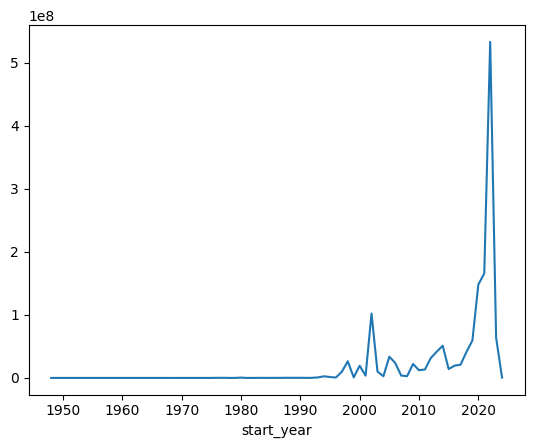

In [ ]:
clinical_df[clinical_df.start_year <= 2024].groupby('start_year')['enrollment'].sum().plot(kind = 'line')

In [ ]:
clinical_df[(clinical_df.study_area == 'covid')]

,study_status,study_results,conditions,interventions,primary_outcome_measures,secondary_outcome_measures,other_outcome_measures,sponsor,collaborators,sex,...,start_date,primary_completion_date,completion_date,first_posted,results_first_posted,last_update_posted,locations,study_area,start_year,days_to_completion
100262,ACTIVE_NOT_RECRUITING,NO,COVID|ARDS,BIOLOGICAL: PLX-PAD,"Number of ventilator-free days, 28 days","All-cause mortality, 28 and 60 days|Duration o...",NaN,Pluristem Ltd.,NaN,ALL,...,2020-10-19,2021-08-04,2023-01-01,2020-11-03,NaT,2022-12-21,"Charite Campus Virchow, Berlin, 10117, Germany...",covid,2020.0,804.0
100263,UNKNOWN,NO,Covid19|Immune Deficiency|Tonsillitis|Tonsil H...,DIAGNOSTIC_TEST: Physical examination,The primary outcome of our study was the evalu...,NaN,NaN,Selcuk University,NaN,ALL,...,2020-10-01,2021-02-01,2021-02-01,2020-11-30,NaT,2020-11-30,"Selcuk University, Konya, Selcuklu, 42100, Turkey",covid,2020.0,123.0
100264,COMPLETED,YES,COVID-19,DRUG: Hydroxychloroquine,Number of Participants Infected With COVID-19 ...,Time From Study Initiation Until the Occurrenc...,NaN,Baylor Research Institute,NaN,ALL,...,2020-04-03,2020-06-30,2020-06-30,2020-04-03,2021-08-02,2021-08-20,"Baylor University Medical Center, Dallas, Texa...",covid,2020.0,88.0
100265,COMPLETED,NO,Corona Virus Infection,"OTHER: Aerobics exercises, Balance exercises","SPSS for Windows, version 22 (SPSS Inc., Chica...",NaN,NaN,Merit University,NaN,ALL,...,2021-08-01,2022-10-25,2023-02-10,2021-08-09,NaT,2023-02-22,"Ahmed.Assem, Sohag, 82951, Egypt",covid,2021.0,558.0
100266,ACTIVE_NOT_RECRUITING,NO,Covid19,DRUG: Niclosamide|DRUG: Placebo,"SAEs, Serious adverse event (SAE) coded by Sys...","Clinical Severity Score, Proportion of patient...",NaN,"First Wave BioPharma, Inc.",NaN,ALL,...,2021-04-30,2022-06-04,2023-05-01,2021-04-26,NaT,2023-04-06,"Central Alabama Research, Birmingham, Alabama,...",covid,2021.0,731.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109599,RECRUITING,NO,Covid19,OTHER: Questionnaire,"Natural history, Description of the natural hi...","School opening, Study of the impact of school ...",NaN,University of Padova,Azienda ULSS 5 Polesana|Imperial College London,ALL,...,2021-11-03,2021-12-31,2022-06-30,2021-11-30,NaT,2021-11-30,"AULSS 5 Polesana, Rovigo, RO, Italy",covid,2021.0,239.0
109600,RECRUITING,NO,COVID-19,DIAGNOSTIC_TEST: Questionnaires,"Fatigue Assessment Scale, Scale that measures ...",Modified Medical Research Council Dyspnea Scal...,NaN,University of Valencia,NaN,FEMALE,...,2022-12-29,2023-02-28,2023-06-30,2022-12-30,NaT,2023-01-04,"University of Valencia, Valencia, 46010, Spain",covid,2022.0,183.0
109601,NOT_YET_RECRUITING,NO,Inflammatory Bowel Diseases,BIOLOGICAL: Influenza vaccine|BIOLOGICAL: COVI...,"Influenza or COVID-17 antibody concentrations,...",Correlation between Fecal Metabolomic Activity...,NaN,"University of Wisconsin, Madison",NaN,ALL,...,2023-10-01,2024-09-01,2024-09-01,2022-10-18,NaT,2023-10-05,NaN,covid,2023.0,336.0
109602,COMPLETED,NO,COVID-19,BIOLOGICAL: SARS-CoV-2 protein subunit recombi...,"Immunogenicity of the candidate vaccine, seroc...","Safety of the candidate vaccine, percentage of...",NaN,PT Bio Farma,"Faculty of Medicine, Universitas Indonesia, Ja...",ALL,...,2022-04-13,2022-07-22,2023-02-28,2022-04-06,NaT,2023-04-13,"Faculty of Medicine, Diponegoro University, Se...",covid,2022.0,321.0
